# Coverage of Confidence Intervals: Exact vs. CLT (Large-Sample)
$$
\newcommand{\Bern}{\mathrm{Bern}}
\newcommand{\Bin}{\mathrm{Bin}}
\newcommand{\E}{\mathbb{E}}
\newcommand{\Var}{\mathrm{Var}}
\newcommand{\phat}{\widehat{p}}
\newcommand{\Xbar}{\overline{X}}
\newcommand{\Ybar}{\overline{Y}}
\newcommand{\zalpha}{z_{1-\alpha/2}}
$$

This notebook compares **empirical coverage** of confidence intervals built using:

- **Exact (true sampling distribution)**  
  - Bernoulli mean $p$: **Clopper-Pearson** (Binomial inversion)  
  - Exponential mean $\mu = 1/\lambda$: **Chi-square / Gamma** (exact from $\sum_i X_i$)

- **Large-sample CLT intervals**  
  - Bernoulli mean $p$: Wald $\phat \pm \zalpha\sqrt{\phat(1-\phat)/n}$ 
  - Exponential mean $\mu$: $\Xbar \pm \zalpha\, \Xbar/\sqrt{n}$ (since $\sigma = \mu$)

You can experiment with different sample sizes and see how coverage changes.


In [6]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import classlib as cl
from scipy.stats import norm, beta, chi2

%matplotlib inline

cl.nbviz.init(use_tex=True)
colors = cl.nbviz.TOL_BRIGHT
cl.nbviz.configure(figpath="_figures/coverage_exact_vs_clt", savefigs=True, imgfrmt="png")  #change to "...figures/..." to track


## Helpers: Exact and CLT intervals


In [7]:
def ci_bernoulli_clopper_pearson(x: int, n: int, alpha: float = 0.05):
    '''
    Exact (Clopper-Pearson) CI for Bernoulli p based on X ~ Binomial(n, p).
    Uses Beta quantiles.
    '''
    if n <= 0:
        raise ValueError("n must be positive")
    if not (0 <= x <= n):
        raise ValueError("x must be in {0,...,n}")

    lo = 0.0 if x == 0 else beta.ppf(alpha/2, x, n - x + 1)
    hi = 1.0 if x == n else beta.ppf(1 - alpha/2, x + 1, n - x)
    return lo, hi


def ci_bernoulli_wald(phat: float, n: int, alpha: float = 0.05):
    '''
    Large-sample (Wald) CI for p.
    '''
    z = norm.ppf(1 - alpha/2)
    se = np.sqrt(phat * (1 - phat) / n)
    return phat - z * se, phat + z * se


def ci_expon_rate_exact(sum_x: float, n: int, alpha: float = 0.05):
    '''
    Exact CI for exponential rate lambda when X_i iid Exp(rate=lambda).
    If S = sum X_i, then 2*lambda*S ~ chi2(df=2n).

      lambda_L = chi2.ppf(alpha/2, 2n) / (2S)
      lambda_U = chi2.ppf(1-alpha/2, 2n) / (2S)
    '''
    if sum_x <= 0:
        return (np.nan, np.nan)
    df = 2 * n
    lo = chi2.ppf(alpha/2, df) / (2 * sum_x)
    hi = chi2.ppf(1 - alpha/2, df) / (2 * sum_x)
    return lo, hi

def ci_expon_mean_exact(sum_x: float, n: int, alpha: float = 0.05):
    '''
    Exact CI for exponential mean mu = 1/lambda when X_i iid Exp(rate=lambda).

    If S = sum X_i, then 2*lambda*S ~ chi2(df=2n). Since mu = 1/lambda,

      mu_L = 2S / chi2.ppf(1-alpha/2, 2n)
      mu_U = 2S / chi2.ppf(alpha/2, 2n)
    '''
    if sum_x <= 0:
        return (np.nan, np.nan)
    df = 2 * n
    lo = (2 * sum_x) / chi2.ppf(1 - alpha/2, df)
    hi = (2 * sum_x) / chi2.ppf(alpha/2, df)
    return lo, hi


def ci_expon_mean_clt(xbar: float, n: int, alpha: float = 0.05):
    '''
    Large-sample (CLT) CI for the exponential mean mu = E[X].

    For Exp(lambda), Var(X) = mu^2, so SE(Xbar) ≈ mu/sqrt(n).
    We plug in mu_hat = Xbar, giving:

      Xbar +- z * Xbar/sqrt(n)
    '''
    z = norm.ppf(1 - alpha/2)
    se = xbar / np.sqrt(n)
    return xbar - z * se, xbar + z * se




## Simulation engine

We compute coverage for each method by Monte Carlo simulation.

- For Bernoulli: generate $n$ Bernoulli trials, compute $\phat$, and build both intervals.
- For Exponential: generate $n$ $\mathrm{Exp}(\lambda)$ samples, compute $S=\sum_i X_i$ and $\Xbar=S/n$, and build intervals for $\mu=1/\lambda$.



In [8]:
def coverage_bernoulli(p: float, n: int, reps: int = 50_000, alpha: float = 0.05, seed: int = 12345):
    rng_local = np.random.default_rng(seed)
    x = rng_local.binomial(n, p, size=reps)
    phat = x / n

    # Exact
    exact_contains = np.empty(reps, dtype=bool)
    for i in range(reps):
        lo, hi = ci_bernoulli_clopper_pearson(int(x[i]), n, alpha)
        exact_contains[i] = (lo <= p <= hi)

    # CLT (Wald)
    z = norm.ppf(1 - alpha/2)
    se = np.sqrt(phat * (1 - phat) / n)
    lo = phat - z * se
    hi = phat + z * se
    wald_contains = (lo <= p) & (p <= hi)

    # Average interval lengths (exact length approximated by subsampling)
    m = min(5000, reps)
    exact_lengths = np.empty(m)
    for i in range(m):
        a, b = ci_bernoulli_clopper_pearson(int(x[i]), n, alpha)
        exact_lengths[i] = b - a

    return {
        "n": n,
        "p": p,
        "reps": reps,
        "alpha": alpha,
        "coverage_exact": float(exact_contains.mean()),
        "coverage_clt_wald": float(wald_contains.mean()),
        "avg_length_exact": float(exact_lengths.mean()),
        "avg_length_clt_wald": float(np.mean(hi - lo)),
    }

def coverage_exponential(lam: float, n: int, reps: int = 50_000, alpha: float = 0.05, seed: int = 12345):
    '''
    Compare coverage for the exponential mean mu = 1/lambda:

      - Exact CI for mu (chi-square / Gamma pivot based on S = sum X_i)
      - CLT CI for mu using Var(X)=mu^2 and plug-in mu_hat = Xbar
    '''
    rng_local = np.random.default_rng(seed)
    x = rng_local.exponential(scale=1/lam, size=(reps, n))
    s = x.sum(axis=1)
    xbar = s / n

    mu = 1/lam

    # Exact mu CI
    lo_e = np.empty(reps)
    hi_e = np.empty(reps)
    for i in range(reps):
        lo_e[i], hi_e[i] = ci_expon_mean_exact(float(s[i]), n, alpha)
    exact_contains = (lo_e <= mu) & (mu <= hi_e)

    # CLT mu CI (plug-in)
    z = norm.ppf(1 - alpha/2)
    se = xbar / np.sqrt(n)
    lo_m = xbar - z * se
    hi_m = xbar + z * se
    clt_contains = (lo_m <= mu) & (mu <= hi_m)

    return {
        "n": n,
        "lambda": lam,
        "mu": mu,
        "reps": reps,
        "alpha": alpha,
        "coverage_exact_mu": float(exact_contains.mean()),
        "coverage_clt_mu": float(clt_contains.mean()),
        "avg_length_exact_mu": float(np.mean(hi_e - lo_e)),
        "avg_length_clt_mu": float(np.mean(hi_m - lo_m)),
    }

# --- Normal example: exact t CI vs CLT z CI for the mean mu (unknown sigma) ---
def coverage_normal(mu: float, sigma: float, n: int, reps: int = 50_000,
                    alpha: float = 0.05, seed: int = 12345):
    rng_local = np.random.default_rng(seed)
    x = rng_local.normal(loc=mu, scale=sigma, size=(reps, n))
    xbar = x.mean(axis=1)
    s = x.std(axis=1, ddof=1)

    se = s / np.sqrt(n)

    # Exact t CI
    tcrit = stats.t.ppf(1 - alpha/2, df=n - 1)
    lo_t = xbar - tcrit * se
    hi_t = xbar + tcrit * se
    t_contains = (lo_t <= mu) & (mu <= hi_t)

    # CLT (plug-in) z CI
    zcrit = norm.ppf(1 - alpha/2)
    lo_z = xbar - zcrit * se
    hi_z = xbar + zcrit * se
    z_contains = (lo_z <= mu) & (mu <= hi_z)

    return {
        "n": n,
        "mu": mu,
        "sigma": sigma,
        "reps": reps,
        "alpha": alpha,
        "coverage_exact_t": float(t_contains.mean()),
        "coverage_clt_z": float(z_contains.mean()),
        "avg_length_exact_t": float(np.mean(hi_t - lo_t)),
        "avg_length_clt_z": float(np.mean(hi_z - lo_z)),
    }



## Single experiment (quick)

Change the parameters below, run the cell, and inspect coverage.

### Bernoulli distribution

In [9]:
p = 0.30  #probability of success = mean
n = 20  #number of samples
reps = 50_000  #number of replications or experiments
alpha = 0.05  #probability of being wrong

res_b = coverage_bernoulli(p=p, n=n, reps=reps, alpha=alpha, seed=2026)
df_b = pd.DataFrame([res_b])
cl.nbviz.display_latex_df(df_b)

,$n$,$p$,reps,$\alpha$,coverage_exact,coverage_clt_wald,avg_length_exact,avg_length_clt_wald
0,20.000,0.300,50000.000,0.050,0.976,0.948,0.414,0.389


### Exponential distribution

In [10]:
lam = 2.0  #rate = 1/mean
n = 10  #number of samples
reps = 50_000  #number of replications or experiments
alpha = 0.05  #probability of being wrong

res_e = coverage_exponential(lam=lam, n=n, reps=reps, alpha=alpha, seed=2026)
df_e = pd.DataFrame([res_e])
cl.nbviz.display_latex_df(df_e)

,$n$,$\lambda$,$\mu$,reps,$\alpha$,coverage_exact_mu,coverage_clt_mu,avg_length_exact_mu,avg_length_clt_mu
0,10.000,2.000,0.500,50000.000,0.050,0.951,0.903,0.748,0.618



## Coverage vs sample size

Pick a grid of sample sizes, $n$, and compare methods on one plot.


In [11]:
def bernoulli_grid(p: float, ns, reps: int = 30_000, alpha: float = 0.05, seed: int = 12345):
    rows = []
    for i, n in enumerate(ns):
        rows.append(coverage_bernoulli(p=p, n=int(n), reps=reps, alpha=alpha, seed=seed + i))
    return pd.DataFrame(rows)

def exponential_grid(lam: float, ns, reps: int = 30_000, alpha: float = 0.05, seed: int = 12345):
    rows = []
    for i, n in enumerate(ns):
        rows.append(coverage_exponential(lam=lam, n=int(n), reps=reps, alpha=alpha, seed=seed + i))
    return pd.DataFrame(rows)

def normal_grid(mu: float, sigma: float, ns: list[int], reps: int = 50_000,
                alpha: float = 0.05, seed: int = 12345):
    rows = []
    for k, n in enumerate(ns):
        rows.append(
            coverage_normal(mu=mu, sigma=sigma, n=n,
                            reps=reps, alpha=alpha, seed=seed + k)
        )
    return pd.DataFrame(rows)

### Bernoulli distribution

In [12]:
p = 0.30
ns = [5, 10, 15, 20, 30, 50, 100, 200]
reps = 30_000
alpha = 0.05

dfb = bernoulli_grid(p=p, ns=ns, reps=reps, alpha=alpha, seed=2026)
cl.nbviz.display_latex_df(dfb)

,$n$,$p$,reps,$\alpha$,coverage_exact,coverage_clt_wald,avg_length_exact,avg_length_clt_wald
0,5.000,0.300,30000.000,0.050,0.997,0.801,0.721,0.651
1,10.000,0.300,30000.000,0.050,0.989,0.843,0.560,0.527
2,15.000,0.300,30000.000,0.050,0.980,0.950,0.470,0.444
3,20.000,0.300,30000.000,0.050,0.976,0.948,0.413,0.389
4,30.000,0.300,30000.000,0.050,0.974,0.953,0.341,0.321
5,50.000,0.300,30000.000,0.050,0.970,0.935,0.264,0.251
6,100.000,0.300,30000.000,0.050,0.962,0.950,0.186,0.178
7,200.000,0.300,30000.000,0.050,0.953,0.942,0.131,0.127


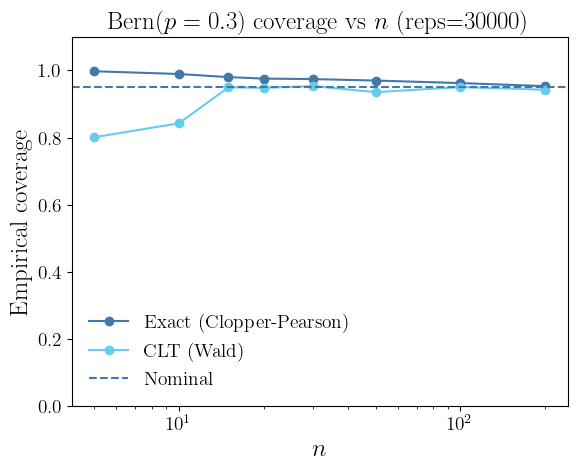

In [13]:
plt.figure()
plt.plot(dfb["n"], dfb["coverage_exact"], marker="o", label="Exact (Clopper-Pearson)")
plt.plot(dfb["n"], dfb["coverage_clt_wald"], marker="o", label="CLT (Wald)")
plt.axhline(1 - dfb["alpha"].iloc[0], linestyle="--", label="Nominal")
plt.xscale("log")
plt.ylim(0, 1.1)
plt.xlabel("$n$")
plt.ylabel("Empirical coverage")
plt.title(rf"Bern($p= {p}$) coverage vs $n$ (reps={reps})")
plt.legend()
cl.nbviz.savefig("bernoulli_coverage_vs_n");

### Exponential distribution

In [14]:
# Exponential grid
lam = 2.0
ns = [2, 3, 5, 10, 20, 30, 50, 100]
reps = 30_000
alpha = 0.05

dfe = exponential_grid(lam=lam, ns=ns, reps=reps, alpha=alpha, seed=2026)
cl.nbviz.display_latex_df(dfe)

,$n$,$\lambda$,$\mu$,reps,$\alpha$,coverage_exact_mu,coverage_clt_mu,avg_length_exact_mu,avg_length_clt_mu
0,2.000,2.000,0.500,30000.000,0.050,0.950,0.794,3.938,1.382
1,3.000,2.000,0.500,30000.000,0.050,0.951,0.828,2.215,1.131
2,5.000,2.000,0.500,30000.000,0.050,0.949,0.871,1.297,0.878
3,10.000,2.000,0.500,30000.000,0.050,0.951,0.907,0.750,0.620
4,20.000,2.000,0.500,30000.000,0.050,0.952,0.927,0.482,0.439
5,30.000,2.000,0.500,30000.000,0.050,0.949,0.935,0.381,0.358
6,50.000,2.000,0.500,30000.000,0.050,0.950,0.940,0.288,0.277
7,100.000,2.000,0.500,30000.000,0.050,0.951,0.945,0.200,0.196


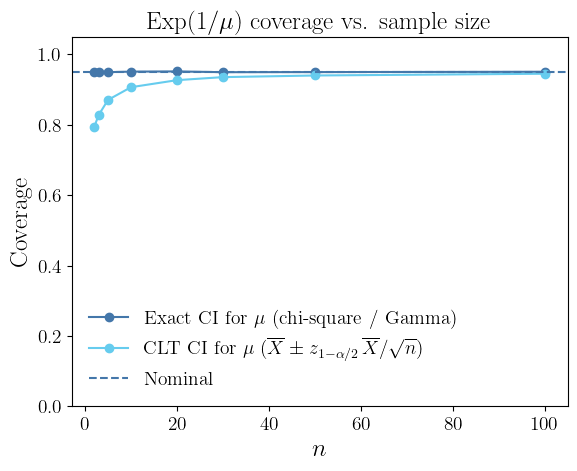

In [25]:
plt.figure()
plt.plot(dfe["n"], dfe["coverage_exact_mu"], marker="o", label="Exact CI for $\mu$ (chi-square / Gamma)")
# plt.plot(dfe["n"], dfe["coverage_clt_mu"], marker="o", label="CLT CI for $\mu$ ($\Xbar \pm \zalpha\, \Xbar/\sqrt{n}$)")
plt.plot(dfe["n"], dfe["coverage_clt_mu"], marker="o", label=r"CLT CI for $\mu$ ($\overline{X} \pm z_{1-\alpha/2}\,\overline{X}/\sqrt{n})$")
plt.axhline(1 - dfe["alpha"].iloc[0], linestyle="--", label="Nominal")
plt.ylim(0, 1.05)
plt.xlabel("$n$")
plt.ylabel("Coverage")
plt.title("Exp($1/\mu$) coverage vs. sample size")
plt.legend()
cl.nbviz.savefig("exponential_coverage_vs_n");

### Normal distribution

In [22]:
mu = 0.0  #true mean
sigma = 1.0  #true standard deviation
ns = [2, 5, 8, 11, 15, 20, 30, 50, 100, 200]
reps = 30_000
alpha = 0.05

dfn = normal_grid(mu=mu, sigma=sigma, ns=ns, reps=reps, alpha=alpha, seed=2026)
cl.nbviz.display_latex_df(dfn)

,$n$,$\mu$,sigma,reps,$\alpha$,coverage_exact_t,coverage_clt_z,avg_length_exact_t,avg_length_clt_z
0,2.000,0.000,1.000,30000.000,0.050,0.951,0.699,14.350,2.214
1,5.000,0.000,1.000,30000.000,0.050,0.948,0.874,2.332,1.646
2,8.000,0.000,1.000,30000.000,0.050,0.951,0.910,1.618,1.342
3,11.000,0.000,1.000,30000.000,0.050,0.948,0.919,1.309,1.151
4,15.000,0.000,1.000,30000.000,0.050,0.949,0.929,1.087,0.993
5,20.000,0.000,1.000,30000.000,0.050,0.949,0.932,0.924,0.865
6,30.000,0.000,1.000,30000.000,0.050,0.951,0.942,0.739,0.709
7,50.000,0.000,1.000,30000.000,0.050,0.951,0.945,0.566,0.552
8,100.000,0.000,1.000,30000.000,0.050,0.950,0.948,0.396,0.391
9,200.000,0.000,1.000,30000.000,0.050,0.950,0.949,0.279,0.277


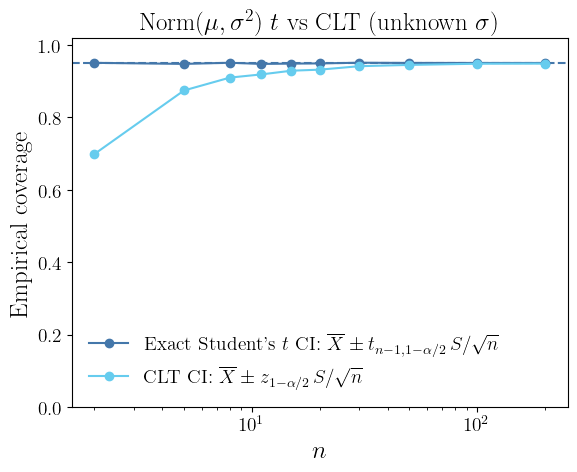

In [23]:
plt.figure()
plt.axhline(1 - alpha, linestyle="--")
plt.plot(dfn["n"], dfn["coverage_exact_t"], marker="o",
         label=r"Exact Student's $t$ CI: $\overline{X} \pm t_{n-1,1-\alpha/2}\,S/\sqrt{n}$")
plt.plot(dfn["n"], dfn["coverage_clt_z"], marker="o",
         label=r"CLT CI: $\overline{X} \pm z_{1-\alpha/2}\,S/\sqrt{n}$")
plt.xscale("log")
plt.ylim(0, 1.02)
plt.xlabel(r"$n$")
plt.ylabel("Empirical coverage")
plt.title(r"Norm$(\mu,\sigma^2)$ $t$ vs CLT (unknown $\sigma$)")
plt.legend()
cl.nbviz.savefig("normal_t_vs_clt_coverage")

Note:  If $\sigma$ is known, then the CLT CI based on $\sigma$ is exact even for small $n$


## Coverage vs proportion for Bernoulli

Scan over a parameter grid at a fixed $n$  with $p \in \{0.05, 0.10, ..., 0.95\}$


In [11]:
def bernoulli_param_scan(ps, n: int, reps: int = 30_000, alpha: float = 0.05, seed: int = 12345):
    rows = []
    for i, p in enumerate(ps):
        rows.append(coverage_bernoulli(p=float(p), n=n, reps=reps, alpha=alpha, seed=seed + i))
    return pd.DataFrame(rows)

ps = np.linspace(0.05, 0.95, 19)
n = 20
reps = 30_000
alpha = 0.05

df_scan = bernoulli_param_scan(ps=ps, n=n, reps=reps, alpha=alpha, seed=2026)
cl.nbviz.display_latex_df(df_scan.head())


,$n$,$p$,reps,$\alpha$,coverage_exact,coverage_clt_wald,avg_length_exact,avg_length_clt_wald
0,20.000,0.050,30000.000,0.050,0.984,0.635,0.239,0.145
1,20.000,0.100,30000.000,0.050,0.988,0.879,0.292,0.235
2,20.000,0.150,30000.000,0.050,0.978,0.821,0.333,0.293
3,20.000,0.200,30000.000,0.050,0.978,0.920,0.367,0.335
4,20.000,0.250,30000.000,0.050,0.962,0.895,0.393,0.366


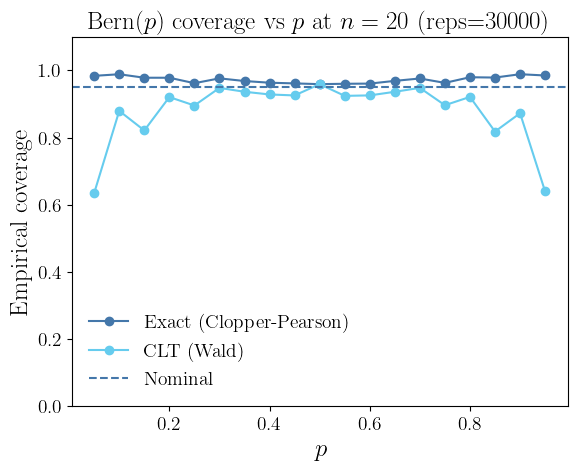

In [12]:
plt.figure()
plt.plot(df_scan["p"], df_scan["coverage_exact"], marker="o", label="Exact (Clopper-Pearson)")
plt.plot(df_scan["p"], df_scan["coverage_clt_wald"], marker="o", label="CLT (Wald)")
plt.axhline(1 - df_scan["alpha"].iloc[0], linestyle="--", label="Nominal")
plt.ylim(0, 1.1)
plt.xlabel("$p$")
plt.ylabel("Empirical coverage")
plt.title(f"Bern$(p)$ coverage vs $p$ at $n={n}$ (reps={reps})")
plt.legend()
cl.nbviz.savefig("bernoulli_coverage_vs_p");


## Notes / talking points

- Exact methods can be conservative in small samples (coverage often above nominal).
- Wald for Bernoulli can undercover badly when $p$ is near 0 or 1, or when $n$ is small.
- For exponential data, the exact CI for $\mu$ comes from a chi-square (Gamma) pivot for $S=\sum_i X_i$.
- The CLT CI for $\mu$ improves as $n$ grows, but can still miscalibrate for small $n$.

